In this notebook we will compare the MBR scores calculated with the monte-carlo estimates and those from the predictive model
We will try to analyse failure points and think about how to tackle those.



In [8]:
# Some setup code for imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from custom_datasets.BayesRiskDatasetLoader import BayesRiskDatasetLoader


In [10]:

# First we will load the test set with the calculated scores.
dataset_loader = BayesRiskDatasetLoader("test", n_hypotheses=100, n_references=1000, sampling_method='ancestral')


In [11]:
dataset = dataset_loader.load(type="pandas")

                                                 source  \
0                             Ich denke, Tom mag Maria.   
1                 Wir leben alle auf dem Planeten Erde.   
2       Hast du daran gedacht, warme Socken anzuziehen?   
3       Meine Mama hat zwei Flaschen Apfelsaft gekauft.   
4                    Holen Sie sie jetzt gleich herein!   
...                                                 ...   
4995  Ich empfinde keine persönliche Abneigung gegen...   
4996    Es sieht so aus, als ob es bald aufklaren wird.   
4997             Ich muss gleich das Badezimmer putzen.   
4998      Tom sagte Maria, dass er Elke niedlich finde.   
4999  Es ist das erste Mal, dass ich renne, um den Z...   

                                                 target  \
0                          I think that Tom likes Mary.   
1                          We all live on planet Earth.   
2                  Did you remember to wear warm socks?   
3             My mum bought two bottles of apple juice.

In [31]:
# We will visualize the scores as



<class 'pandas.core.frame.DataFrame'>


In [19]:
import numpy as np
def calculate_mbr_scores(entry, n_references=1000):
    scores = []
    count = np.sum(entry["utilities_count"])
    for hyp, util in zip(entry["hypotheses"], entry["utilities"]):
        score = np.sum(util* entry["utilities_count"])/count
        scores.append(score)
    return scores

In [22]:

scores = calculate_mbr_scores(entry)
print(scores)

[1.2385324246883391, 1.1187080875039102, 1.022955731332302, -0.11423761802911758]


In [24]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_scores(hypotheses, scores):


    plt.rcdefaults()
    fig, ax = plt.subplots()

    
    y_pos = np.arange(len(hypotheses))
    
    

    ax.barh(y_pos, scores,align='center')
    ax.set_yticks(y_pos, labels=hypotheses)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('MBR scores')
    ax.set_title('plotting scores')

    plt.show()

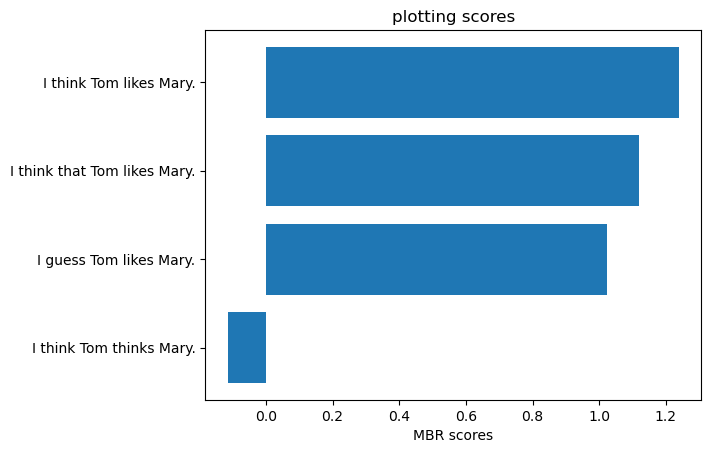

In [25]:
visualize_scores(entry["hypotheses"], scores)

In [ ]:

def visualize_scores_compared(hypotheses, scores):


    plt.rcdefaults()
    fig, ax = plt.subplots()

    
    y_pos = np.arange(len(hypotheses))
    
    

    ax.barh(y_pos, scores,align='center')
    ax.set_yticks(y_pos, labels=hypotheses)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('MBR scores')
    ax.set_title('plotting scores')

    plt.show()